In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import pickle
from sklearn.impute import SimpleImputer

# for regression models
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#performance
from sklearn.metrics import mean_squared_error

# To supress warnings
import warnings
warnings.filterwarnings("ignore")

In [1]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("mlops-project")

2023/07/20 11:30:46 INFO mlflow.tracking.fluent: Experiment with name 'mlops-project' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/tapji/.conda/mlops-project/mlruns/1', creation_time=1689852646451, experiment_id='1', last_update_time=1689852646451, lifecycle_stage='active', name='mlops-project', tags={}>

### Importing dataset

In [2]:
# training dataset

df = pd.read_csv('./data/emission_data.csv', encoding='iso-8859-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4625 entries, 0 to 4624
Data columns (total 45 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Manufacturer                           4625 non-null   object 
 1   Model                                  4625 non-null   object 
 2   Description                            4625 non-null   object 
 3   Transmission                           4386 non-null   object 
 4   Engine Capacity                        4625 non-null   int64  
 5   Fuel Type                              4625 non-null   object 
 6   Powertrain                             4625 non-null   object 
 7   Engine Power (Kw)                      4536 non-null   float64
 8   Engine Power (PS)                      4404 non-null   float64
 9   Testing Scheme                         4625 non-null   object 
 10  Euro Standard                          4625 non-null   object 
 11  Dies

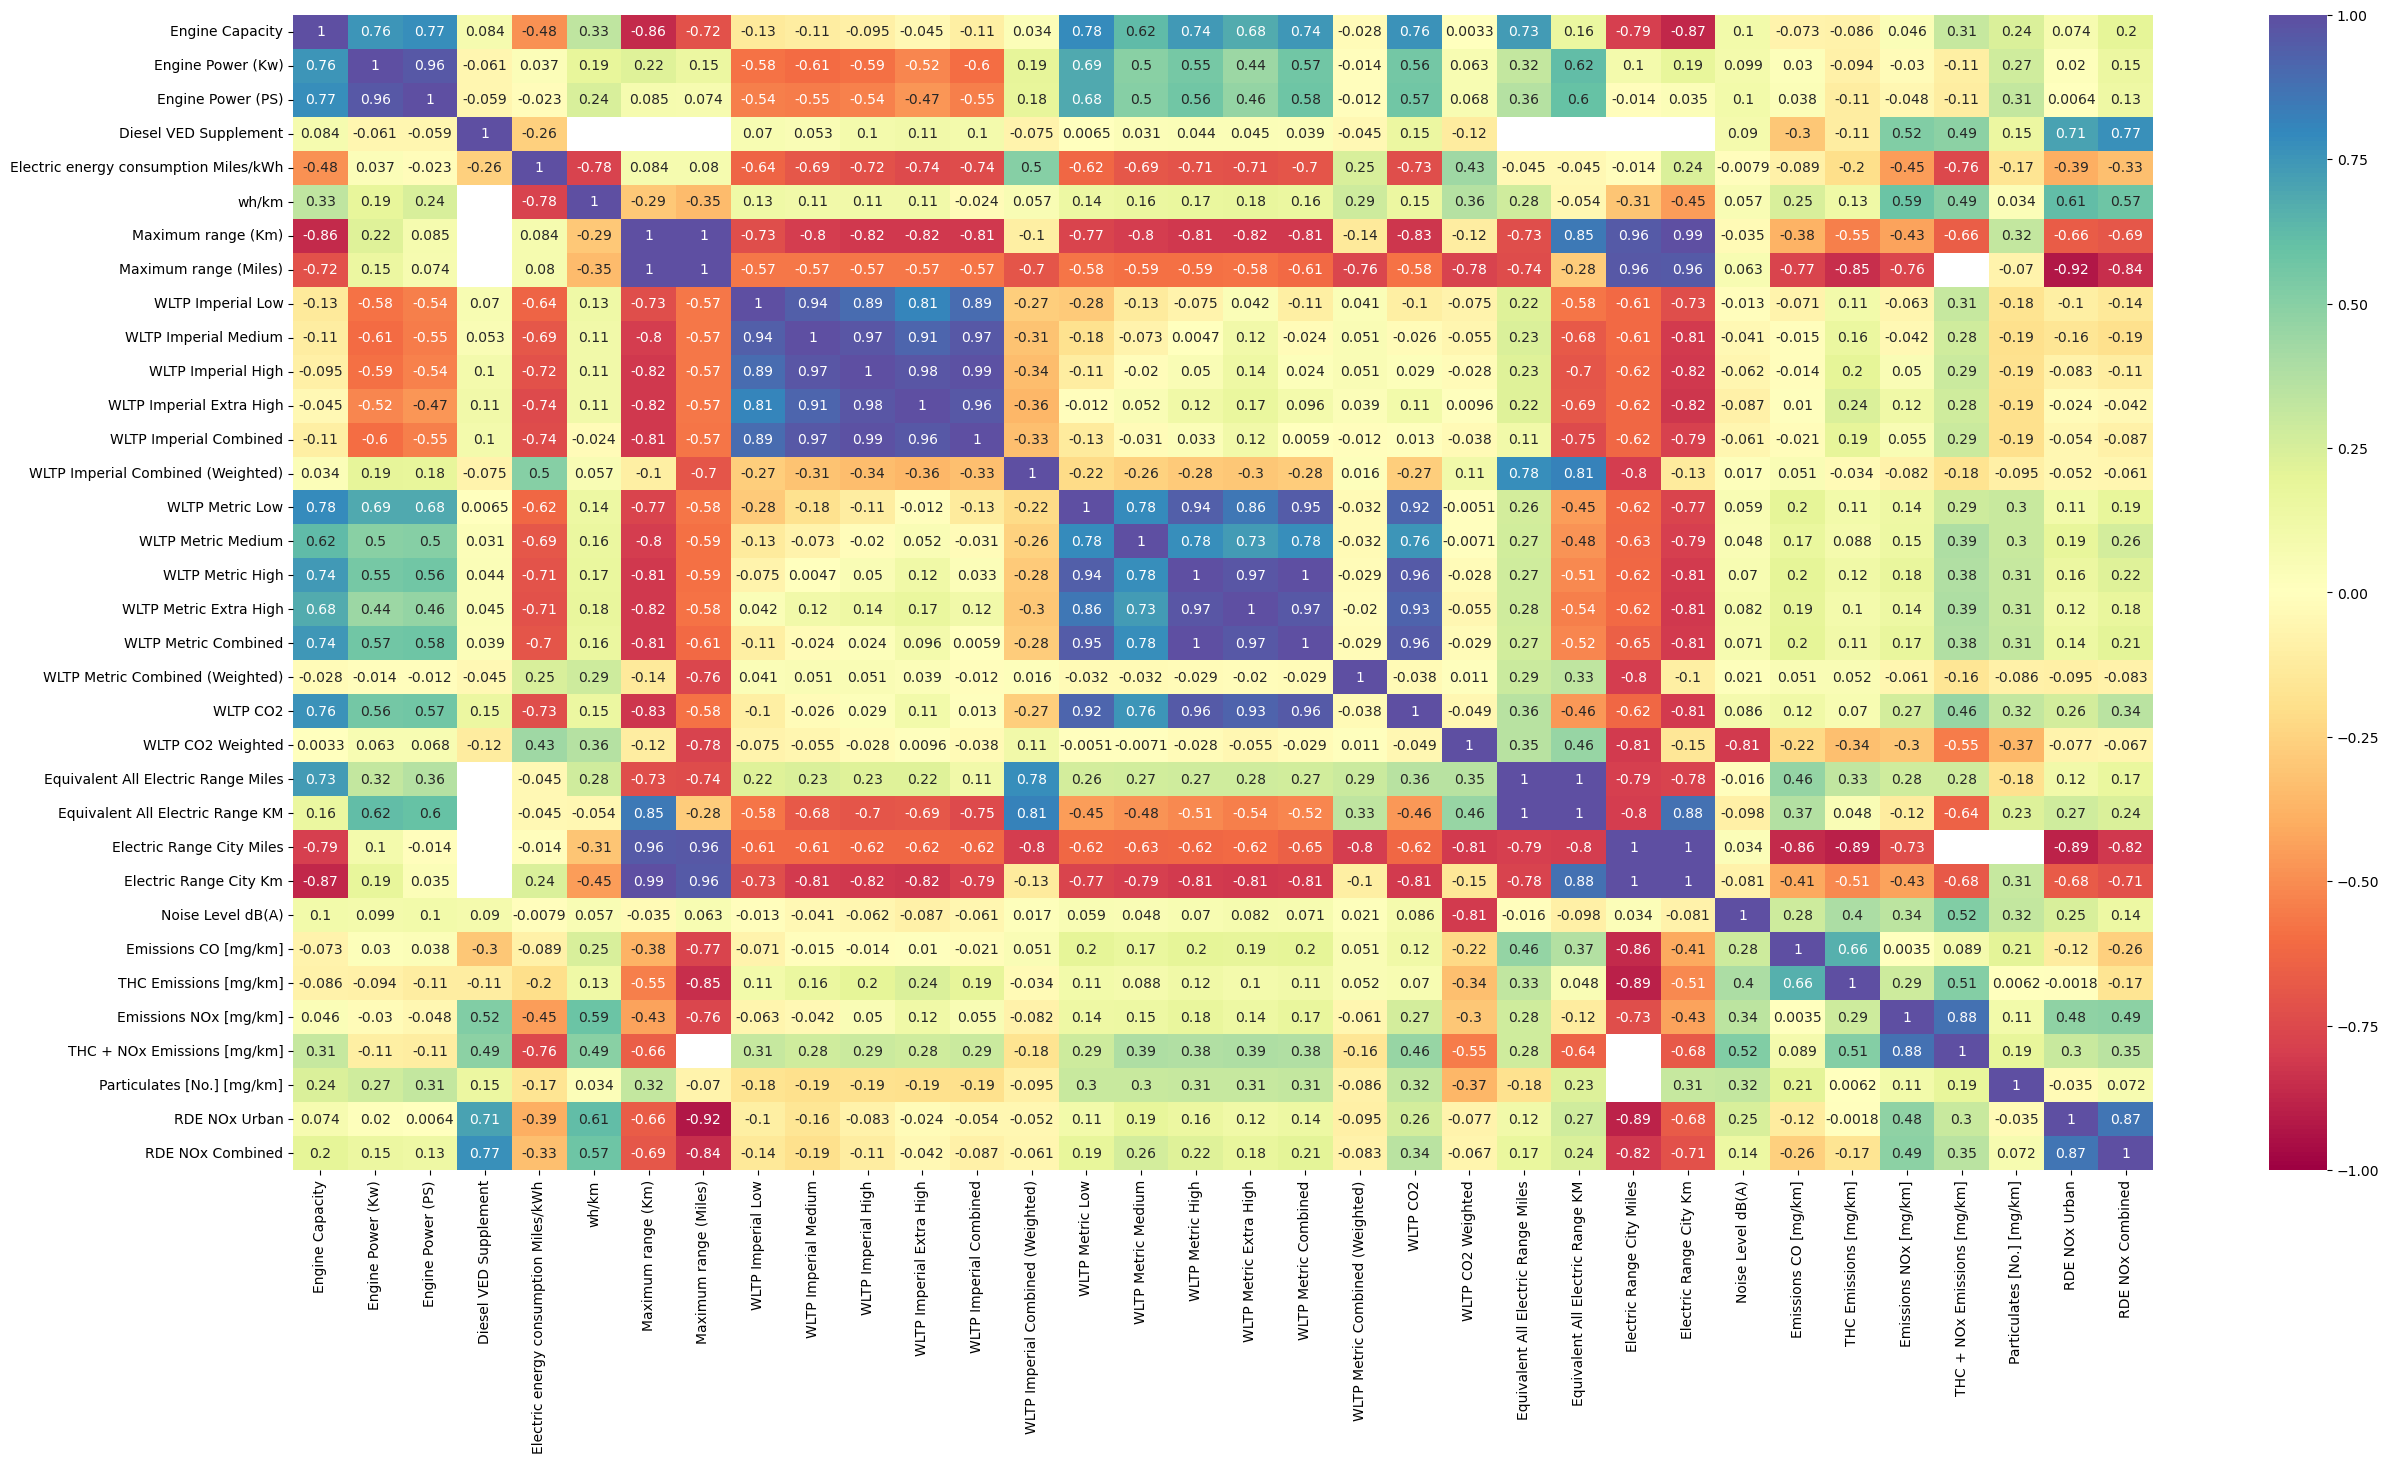

In [3]:
# Observing the correlation between numerical variables using heatmap

plt.figure(figsize=(30,15))
sns.heatmap(df.corr(),annot=True,cmap='Spectral',vmin=-1,vmax=1)
plt.show()

In [4]:
df.isnull().sum()

Manufacturer                                0
Model                                       0
Description                                 0
Transmission                              239
Engine Capacity                             0
Fuel Type                                   0
Powertrain                                  0
Engine Power (Kw)                          89
Engine Power (PS)                         221
Testing Scheme                              0
Euro Standard                               0
Diesel VED Supplement                       0
Electric energy consumption Miles/kWh    3192
wh/km                                    4230
Maximum range (Km)                       3818
Maximum range (Miles)                    4353
WLTP Imperial Low                           6
WLTP Imperial Medium                        5
WLTP Imperial High                          5
WLTP Imperial Extra High                    5
WLTP Imperial Combined                      5
WLTP Imperial Combined (Weighted) 

In [5]:
# Remove '£' and ',' sign from 'Total Cost/ 10000 miles' column and convert to numeric values

df['Annual fuel Cost 10000 Miles'] = df['Annual fuel Cost 10000 Miles'].str.replace('£', '')
df['Annual fuel Cost 10000 Miles'] = df['Annual fuel Cost 10000 Miles'].str.replace(',', '').astype(int)


In [6]:
df['Annual Electricity cost / 10000 miles'] = df['Annual Electricity cost / 10000 miles'].str.replace('£', '')
df['Annual Electricity cost / 10000 miles'] = df['Annual Electricity cost / 10000 miles'].str.replace(',', '').astype(int)

In [7]:
df['Total cost / 10000 miles'] = df['Total cost / 10000 miles'].str.replace('£', '')
df['Total cost / 10000 miles'] = df['Total cost / 10000 miles'].str.replace(',', '').astype(int)
df.head(10)

,Manufacturer,Model,Description,Transmission,Engine Capacity,Fuel Type,Powertrain,Engine Power (Kw),Engine Power (PS),Testing Scheme,...,Annual Electricity cost / 10000 miles,Total cost / 10000 miles,Noise Level dB(A),Emissions CO [mg/km],THC Emissions [mg/km],Emissions NOx [mg/km],THC + NOx Emissions [mg/km],Particulates [No.] [mg/km],RDE NOx Urban,RDE NOx Combined
0,ABARTH,595,595 1.4 145 BHP Convertible,M5,1368,Petrol,Internal Combustion Engine (ICE),107.0,145.0,WLTP,...,0,1935,73.5,760.0,52.0,27.0,NaN,NaN,NaN,NaN
1,ABARTH,595,595 1.4 145 BHP Convertible,M5,1368,Petrol,Internal Combustion Engine (ICE),107.0,145.0,WLTP,...,0,2043,73.5,760.0,52.0,27.0,NaN,NaN,NaN,NaN
2,ABARTH,595,595 1.4 145 BHP Hatchback,M5,1368,Petrol,Internal Combustion Engine (ICE),107.0,145.0,WLTP,...,0,1935,73.5,760.0,52.0,27.0,NaN,NaN,NaN,NaN
3,ABARTH,595,595 1.4 145 BHP Hatchback,M5,1368,Petrol,Internal Combustion Engine (ICE),107.0,145.0,WLTP,...,0,2043,73.5,760.0,52.0,27.0,NaN,NaN,NaN,NaN
4,ABARTH,595,595 1.4 TJET 145bhp,M5,1368,Petrol,Internal Combustion Engine (ICE),107.0,NaN,WLTP,...,0,1828,74.0,829.0,39.0,20.0,NaN,NaN,NaN,NaN
5,ABARTH,595,595 1.4 TJET 145bhp,M5,1368,Petrol,Internal Combustion Engine (ICE),107.0,NaN,WLTP,...,0,1908,74.0,829.0,39.0,20.0,NaN,NaN,NaN,NaN
6,ABARTH,595,595 COMPETIZIONE 1.4 TJET 180bhp,M5,1368,Petrol,Internal Combustion Engine (ICE),132.0,NaN,WLTP,...,0,1854,72.0,561.0,35.0,18.0,NaN,NaN,NaN,NaN
7,ABARTH,595,595 COMPETIZIONE 1.4 TJET 180bhp,SA5,1368,Petrol,Internal Combustion Engine (ICE),132.0,NaN,WLTP,...,0,1881,74.0,493.0,26.0,18.0,NaN,NaN,NaN,NaN
8,ABARTH,595,595 COMPETIZIONE 1.4 TJET 180bhp,SA5,1368,Petrol,Internal Combustion Engine (ICE),132.0,NaN,WLTP,...,0,1962,74.0,493.0,26.0,18.0,NaN,NaN,NaN,NaN
9,ABARTH,595,595 COMPETIZIONE 1.4 TJET 180bhp Convertible,M5,1368,Petrol,Internal Combustion Engine (ICE),132.0,NaN,WLTP,...,0,1854,72.0,561.0,35.0,18.0,NaN,NaN,NaN,NaN


In [8]:
# Verify the column names
print(df.columns)

Index(['Manufacturer', 'Model', 'Description', 'Transmission',
       'Engine Capacity', 'Fuel Type', 'Powertrain', 'Engine Power (Kw)',
       'Engine Power (PS)', 'Testing Scheme', 'Euro Standard',
       'Diesel VED Supplement', 'Electric energy consumption Miles/kWh',
       'wh/km', 'Maximum range (Km)', 'Maximum range (Miles)',
       'WLTP Imperial Low', 'WLTP Imperial Medium', 'WLTP Imperial High',
       'WLTP Imperial Extra High', 'WLTP Imperial Combined',
       'WLTP Imperial Combined (Weighted)', 'WLTP Metric Low',
       'WLTP Metric Medium', 'WLTP Metric High', 'WLTP Metric Extra High',
       'WLTP Metric Combined', 'WLTP Metric Combined (Weighted)', 'WLTP CO2',
       'WLTP CO2 Weighted', 'Equivalent All Electric Range Miles',
       'Equivalent All Electric Range KM', 'Electric Range City Miles',
       'Electric Range City Km', 'Annual fuel Cost 10000 Miles',
       'Annual Electricity cost / 10000 miles', 'Total cost / 10000 miles',
       'Noise Level dB(A)', 'Emis

In [9]:
# Dropping columns with little or no correlation to emmission values

data = df.drop(['Manufacturer', 'Model', 'Description','Transmission', 'Engine Power (Kw)', 'Engine Power (PS)',
       'Electric energy consumption Miles/kWh', 'wh/km', 'Diesel VED Supplement', 'Testing Scheme', 'Euro Standard', 'Maximum range (Miles)',
       'WLTP Imperial Low', 'WLTP Imperial Medium', 'WLTP Imperial High','WLTP Imperial Extra High', 'WLTP Imperial Combined',
       'WLTP Imperial Combined (Weighted)', 'WLTP Metric Low','WLTP Metric Medium', 'WLTP Metric High', 'WLTP Metric Extra High',
       'WLTP Metric Combined', 'WLTP Metric Combined (Weighted)','WLTP CO2 Weighted', 'Equivalent All Electric Range Miles', 'Electric Range City Miles', 'RDE NOx Urban',], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4625 entries, 0 to 4624
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Engine Capacity                        4625 non-null   int64  
 1   Fuel Type                              4625 non-null   object 
 2   Powertrain                             4625 non-null   object 
 3   Maximum range (Km)                     807 non-null    float64
 4   WLTP CO2                               4623 non-null   float64
 5   Equivalent All Electric Range KM       634 non-null    float64
 6   Electric Range City Km                 826 non-null    float64
 7   Annual fuel Cost 10000 Miles           4625 non-null   int64  
 8   Annual Electricity cost / 10000 miles  4625 non-null   int64  
 9   Total cost / 10000 miles               4625 non-null   int64  
 10  Noise Level dB(A)                      4625 non-null   float64
 11  Emis

In [10]:
data.isnull().sum()

Engine Capacity                             0
Fuel Type                                   0
Powertrain                                  0
Maximum range (Km)                       3818
WLTP CO2                                    2
Equivalent All Electric Range KM         3991
Electric Range City Km                   3799
Annual fuel Cost 10000 Miles                0
Annual Electricity cost / 10000 miles       0
Total cost / 10000 miles                    0
Noise Level dB(A)                           0
Emissions CO [mg/km]                      108
THC Emissions [mg/km]                     958
Emissions NOx [mg/km]                     140
THC + NOx Emissions [mg/km]              3023
Particulates [No.] [mg/km]               2943
RDE NOx Combined                         1934
dtype: int64

In [11]:
# Verify the column names
print(data.columns)

Index(['Engine Capacity', 'Fuel Type', 'Powertrain', 'Maximum range (Km)',
       'WLTP CO2', 'Equivalent All Electric Range KM',
       'Electric Range City Km', 'Annual fuel Cost 10000 Miles',
       'Annual Electricity cost / 10000 miles', 'Total cost / 10000 miles',
       'Noise Level dB(A)', 'Emissions CO [mg/km]', 'THC Emissions [mg/km]',
       'Emissions NOx [mg/km]', 'THC + NOx Emissions [mg/km]',
       'Particulates [No.] [mg/km]', 'RDE NOx Combined'],
      dtype='object')


In [12]:
columns_to_impute = ['Maximum range (Km)', 'WLTP CO2','Equivalent All Electric Range KM',
       'Electric Range City Km', 'Emissions CO [mg/km]', 'THC Emissions [mg/km]',
       'Emissions NOx [mg/km]', 'THC + NOx Emissions [mg/km]',
       'Particulates [No.] [mg/km]','RDE NOx Combined']

imputer = SimpleImputer(strategy='mean')

# Impute the missing values in the specified columns
data[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])
data.isnull().sum()

Engine Capacity                          0
Fuel Type                                0
Powertrain                               0
Maximum range (Km)                       0
WLTP CO2                                 0
Equivalent All Electric Range KM         0
Electric Range City Km                   0
Annual fuel Cost 10000 Miles             0
Annual Electricity cost / 10000 miles    0
Total cost / 10000 miles                 0
Noise Level dB(A)                        0
Emissions CO [mg/km]                     0
THC Emissions [mg/km]                    0
Emissions NOx [mg/km]                    0
THC + NOx Emissions [mg/km]              0
Particulates [No.] [mg/km]               0
RDE NOx Combined                         0
dtype: int64

### Data Pre- Processing

In [13]:
# Observing the summary statistics of the EasyVisadataset (Numerical variables)

round(data.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
Engine Capacity,4625.0,1706.91,916.61,0.0,1199.00,1499.00,1997.00,6749.00
Maximum range (Km),4625.0,123.90,77.12,0.0,123.90,123.90,123.90,779.00
WLTP CO2,4625.0,149.14,61.17,0.0,126.00,144.00,173.00,380.00
Equivalent All Electric Range KM,4625.0,15.61,11.72,0.0,15.61,15.61,15.61,208.00
Electric Range City Km,4625.0,159.91,101.75,0.0,159.91,159.91,159.91,828.00
Annual fuel Cost 10000 Miles,4625.0,1721.32,711.43,0.0,1424.00,1666.00,1989.00,4488.00
Annual Electricity cost / 10000 miles,4625.0,67.03,233.81,0.0,0.00,0.00,0.00,1748.00
Total cost / 10000 miles,4625.0,1788.35,598.87,586.0,1424.00,1680.00,1999.00,4488.00
Noise Level dB(A),4625.0,65.14,15.32,0.0,67.00,68.00,69.00,89.20
Emissions CO [mg/km],4625.0,232.69,200.53,0.0,71.00,187.00,329.00,942.00


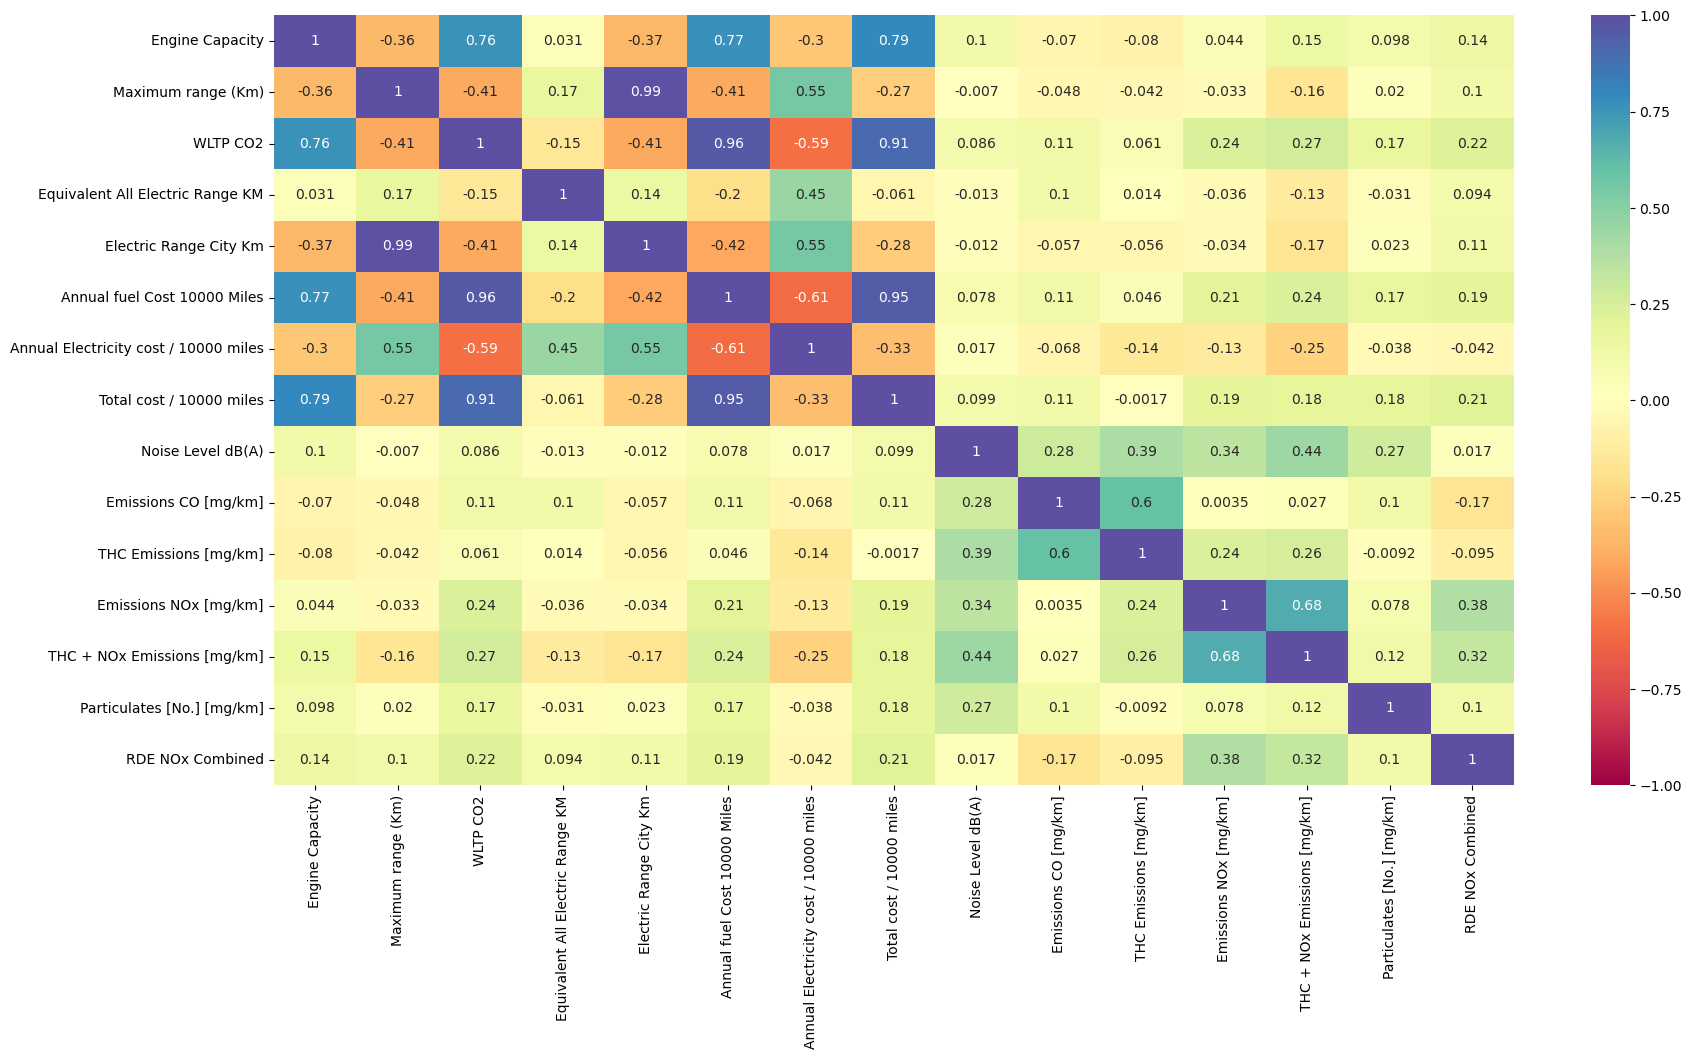

In [14]:
# Observing the correlation between numerical variables using heatmap

plt.figure(figsize=(20,10))
sns.heatmap(data.corr(),annot=True,cmap='Spectral',vmin=-1,vmax=1)
plt.show()

#### Observations



In [15]:
# Converting object datatype to categorical

for feature in data.columns: # Loop through all columns in the dataframe
    if data[feature].dtype == 'object': # Only apply for columns with categorical strings
        data[feature] = pd.Categorical(data[feature])# Replace strings with an integer
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4625 entries, 0 to 4624
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Engine Capacity                        4625 non-null   int64   
 1   Fuel Type                              4625 non-null   category
 2   Powertrain                             4625 non-null   category
 3   Maximum range (Km)                     4625 non-null   float64 
 4   WLTP CO2                               4625 non-null   float64 
 5   Equivalent All Electric Range KM       4625 non-null   float64 
 6   Electric Range City Km                 4625 non-null   float64 
 7   Annual fuel Cost 10000 Miles           4625 non-null   int64   
 8   Annual Electricity cost / 10000 miles  4625 non-null   int64   
 9   Total cost / 10000 miles               4625 non-null   int64   
 10  Noise Level dB(A)                      4625 non-null   float

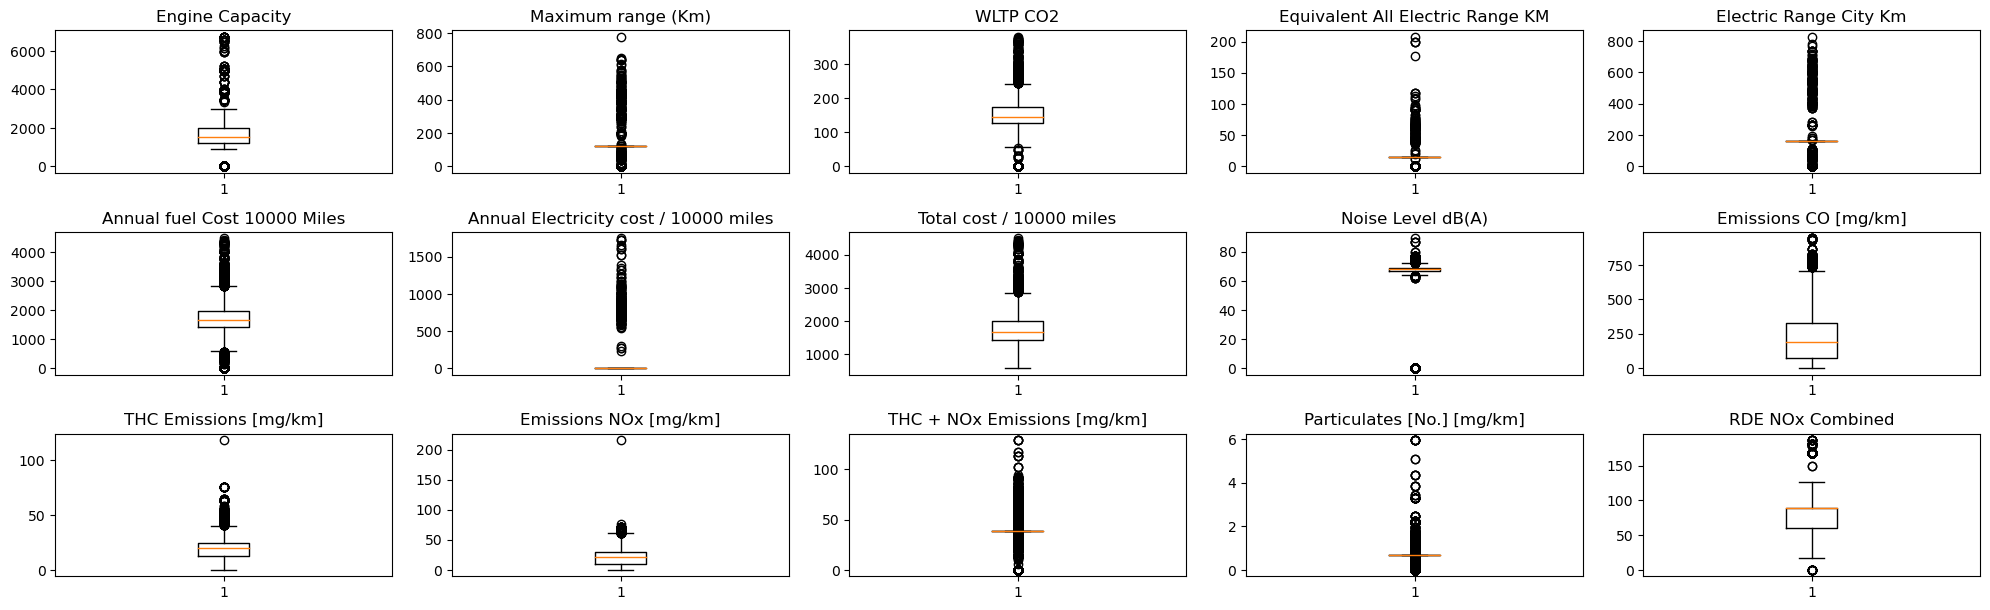

In [16]:
# outlier detection using boxplot

numeric_columns = data.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(20, 10))

for i, variable in enumerate(numeric_columns):
    plt.subplot(5, 5, i + 1)
    plt.boxplot(data[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

### Modelling

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4625 entries, 0 to 4624
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Engine Capacity                        4625 non-null   int64   
 1   Fuel Type                              4625 non-null   category
 2   Powertrain                             4625 non-null   category
 3   Maximum range (Km)                     4625 non-null   float64 
 4   WLTP CO2                               4625 non-null   float64 
 5   Equivalent All Electric Range KM       4625 non-null   float64 
 6   Electric Range City Km                 4625 non-null   float64 
 7   Annual fuel Cost 10000 Miles           4625 non-null   int64   
 8   Annual Electricity cost / 10000 miles  4625 non-null   int64   
 9   Total cost / 10000 miles               4625 non-null   int64   
 10  Noise Level dB(A)                      4625 non-null   float

In [17]:
for col in data.columns:
    if ' ' in col:
        new_col = col.replace(' ', '_')
        data.rename(columns={col: new_col}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4625 entries, 0 to 4624
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Engine_Capacity                        4625 non-null   int64   
 1   Fuel_Type                              4625 non-null   category
 2   Powertrain                             4625 non-null   category
 3   Maximum_range_(Km)                     4625 non-null   float64 
 4   WLTP_CO2                               4625 non-null   float64 
 5   Equivalent_All_Electric_Range_KM       4625 non-null   float64 
 6   Electric_Range_City_Km                 4625 non-null   float64 
 7   Annual_fuel_Cost_10000_Miles           4625 non-null   int64   
 8   Annual_Electricity_cost_/_10000_miles  4625 non-null   int64   
 9   Total_cost_/_10000_miles               4625 non-null   int64   
 10  Noise_Level_dB(A)                      4625 non-null   float

In [18]:
# Separating features and the target column
X = data.drop(["WLTP_CO2"], axis=1)
y = data["WLTP_CO2"]

X = pd.get_dummies(X,drop_first=True)

In [19]:
# Adding intercept to the dataset
X = sm.add_constant(X)
# Splitting X and y into train and test sets in a 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=1
)

In [20]:
olsmod = sm.OLS(y_train, X_train)
olsres = olsmod.fit()
# let's print the regression summary
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:               WLTP_CO2   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     2105.
Date:                Thu, 20 Jul 2023   Prob (F-statistic):               0.00
Time:                        08:34:27   Log-Likelihood:                -13386.
No. Observations:                3237   AIC:                         2.682e+04
Df Residuals:                    3212   BIC:                         2.697e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

## Multi-collinearity checks

In [21]:
# let's check the VIF of the predictors for multicollinearity checks
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_series1 = pd.Series(
    [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])],
    index=X_train.columns,
)
print("VIF values: \n\n{}\n".format(vif_series1))

VIF values: 

const                                                0.000000e+00
Engine_Capacity                                      4.927283e+00
Maximum_range_(Km)                                   4.597883e+01
Equivalent_All_Electric_Range_KM                     2.918922e+00
Electric_Range_City_Km                               5.075588e+01
Annual_fuel_Cost_10000_Miles                         4.509653e+07
Annual_Electricity_cost_/_10000_miles                5.026393e+06
Total_cost_/_10000_miles                             3.181158e+07
Noise_Level_dB(A)                                    1.738575e+00
Emissions_CO_[mg/km]                                 2.603470e+00
THC_Emissions_[mg/km]                                2.092615e+00
Emissions_NOx_[mg/km]                                2.899042e+00
THC_+_NOx_Emissions_[mg/km]                          2.375574e+00
Particulates_[No.]_[mg/km]                           1.172792e+00
RDE_NOx_Combined                                     1.649389e

### 1. Dropping variables with 'inf' VIF due to their high multicollinearity

In [22]:
# Dropping 
X_train1 = X_train.drop(["Fuel_Type_Electricity", "Fuel_Type_Electricity / Diesel", "Fuel_Type_Electricity / Petrol",
                         "Powertrain_Hybrid Electric Vehicle (HEV)", "Powertrain_Internal Combustion Engine (ICE)",
                         "Powertrain_Micro-hybrid", "Powertrain_Mild Hybrid Electric Vehicle (MHEV)",
                         "Powertrain_Plug-in Hybrid Electric Vehicle (PHEV)"], axis=1)
olsmod_1 = sm.OLS(y_train, X_train1)
olsres_1 = olsmod_1.fit()
print(olsres_1.summary())

                            OLS Regression Results                            
Dep. Variable:               WLTP_CO2   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     2598.
Date:                Thu, 20 Jul 2023   Prob (F-statistic):               0.00
Time:                        08:34:57   Log-Likelihood:                -13506.
No. Observations:                3237   AIC:                         2.705e+04
Df Residuals:                    3218   BIC:                         2.717e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [23]:
# let's check the VIF of the predictors for multicollinearity checks

vif_series2 = pd.Series(
    [variance_inflation_factor(X_train1.values, i) for i in range(X_train1.shape[1])],
    index=X_train1.columns,
)
print("VIF values: \n\n{}\n".format(vif_series2))

VIF values: 

const                                    6.001613e+01
Engine_Capacity                          4.340191e+00
Maximum_range_(Km)                       4.560317e+01
Equivalent_All_Electric_Range_KM         1.670815e+00
Electric_Range_City_Km                   4.645323e+01
Annual_fuel_Cost_10000_Miles             4.314605e+07
Annual_Electricity_cost_/_10000_miles    4.805408e+06
Total_cost_/_10000_miles                 3.043469e+07
Noise_Level_dB(A)                        1.675643e+00
Emissions_CO_[mg/km]                     2.482700e+00
THC_Emissions_[mg/km]                    2.052013e+00
Emissions_NOx_[mg/km]                    2.739957e+00
THC_+_NOx_Emissions_[mg/km]              2.341847e+00
Particulates_[No.]_[mg/km]               1.167312e+00
RDE_NOx_Combined                         1.634175e+00
Fuel_Type_Diesel Electric                1.080587e+00
Fuel_Type_Petrol                         3.838312e+00
Fuel_Type_Petrol / LPG                   1.314115e+00
Fuel_Type_Petr

### 2. Dropping 'Annual_fuel_Cost_10000_Miles' column from the model

In [24]:
X_train2 = X_train1.drop(["Annual_fuel_Cost_10000_Miles"], axis=1)
olsmod_2 = sm.OLS(y_train, X_train2)
olsres_2 = olsmod_2.fit()
print(olsres_2.summary())

                            OLS Regression Results                            
Dep. Variable:               WLTP_CO2   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     2688.
Date:                Thu, 20 Jul 2023   Prob (F-statistic):               0.00
Time:                        08:35:15   Log-Likelihood:                -13542.
No. Observations:                3237   AIC:                         2.712e+04
Df Residuals:                    3219   BIC:                         2.723e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [26]:
# let's check the VIF of the predictors for multicollinearity checks
vif_series2 = pd.Series(
[variance_inflation_factor(X_train2.values, i) for i in range(X_train2.shape[1])],
index=X_train2.columns,)
print("VIF values: \n\n{}\n".format(vif_series2))

VIF values: 

const                                    59.995730
Engine_Capacity                           4.296300
Maximum_range_(Km)                       43.641962
Equivalent_All_Electric_Range_KM          1.545483
Electric_Range_City_Km                   44.464516
Annual_Electricity_cost_/_10000_miles     2.543827
Total_cost_/_10000_miles                  4.710402
Noise_Level_dB(A)                         1.675638
Emissions_CO_[mg/km]                      2.471412
THC_Emissions_[mg/km]                     2.041536
Emissions_NOx_[mg/km]                     2.737395
THC_+_NOx_Emissions_[mg/km]               2.331044
Particulates_[No.]_[mg/km]                1.166014
RDE_NOx_Combined                          1.626473
Fuel_Type_Diesel Electric                 1.080058
Fuel_Type_Petrol                          3.837250
Fuel_Type_Petrol / LPG                    1.311641
Fuel_Type_Petrol Electric                 2.533344
dtype: float64



### 3. Dropping 'Electric_Range_City_Km' column from the model

In [27]:
X_train3 = X_train2.drop(["Electric_Range_City_Km"], axis=1)
olsmod_3 = sm.OLS(y_train, X_train3)
olsres_3 = olsmod_3.fit()
print(olsres_3.summary())

                            OLS Regression Results                            
Dep. Variable:               WLTP_CO2   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     2733.
Date:                Thu, 20 Jul 2023   Prob (F-statistic):               0.00
Time:                        08:36:56   Log-Likelihood:                -13608.
No. Observations:                3237   AIC:                         2.725e+04
Df Residuals:                    3220   BIC:                         2.735e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [28]:
# let's check the VIF of the predictors for multicollinearity checks

vif_series3 = pd.Series(
    [variance_inflation_factor(X_train3.values, i) for i in range(X_train3.shape[1])],
    index=X_train3.columns,
)
print("VIF values: \n\n{}\n".format(vif_series3))

VIF values: 

const                                    59.503695
Engine_Capacity                           4.294014
Maximum_range_(Km)                        1.644541
Equivalent_All_Electric_Range_KM          1.511657
Annual_Electricity_cost_/_10000_miles     2.530378
Total_cost_/_10000_miles                  4.707398
Noise_Level_dB(A)                         1.675489
Emissions_CO_[mg/km]                      2.466428
THC_Emissions_[mg/km]                     2.025107
Emissions_NOx_[mg/km]                     2.733515
THC_+_NOx_Emissions_[mg/km]               2.319195
Particulates_[No.]_[mg/km]                1.165165
RDE_NOx_Combined                          1.625313
Fuel_Type_Diesel Electric                 1.080052
Fuel_Type_Petrol                          3.830563
Fuel_Type_Petrol / LPG                    1.311564
Fuel_Type_Petrol Electric                 2.532678
dtype: float64



**Observations**

1. Since the VIF are less than 5, we have no effect of multicollinearity. We can also trust the p-values to remove insignificant predictors.
2. We will now remove insignificant predictors

### 4. Dropping 'Fuel_Type_Diesel Electric' column from the training set

In [29]:
X_train4 = X_train3.drop(["Fuel_Type_Diesel Electric"], axis=1)
olsmod_4 = sm.OLS(y_train, X_train4)
olsres_4 = olsmod_4.fit()
print(olsres_4.summary())

                            OLS Regression Results                            
Dep. Variable:               WLTP_CO2   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     2916.
Date:                Thu, 20 Jul 2023   Prob (F-statistic):               0.00
Time:                        08:37:32   Log-Likelihood:                -13609.
No. Observations:                3237   AIC:                         2.725e+04
Df Residuals:                    3221   BIC:                         2.735e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### 5. Dropping 'Emissions_NOx_[mg/km]' column from the training set

In [30]:
X_train5 = X_train4.drop(["Emissions_NOx_[mg/km]"], axis=1)
olsmod_5 = sm.OLS(y_train, X_train5)
olsres_5 = olsmod_5.fit()
print(olsres_5.summary())

                            OLS Regression Results                            
Dep. Variable:               WLTP_CO2   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     3125.
Date:                Thu, 20 Jul 2023   Prob (F-statistic):               0.00
Time:                        08:37:44   Log-Likelihood:                -13609.
No. Observations:                3237   AIC:                         2.725e+04
Df Residuals:                    3222   BIC:                         2.734e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### 5. Dropping 'RDE_NOx_Combined' column from the training set

In [31]:
X_train6 = X_train5.drop(["RDE_NOx_Combined"], axis=1)
olsmod_6 = sm.OLS(y_train, X_train6)
olsres_6 = olsmod_6.fit()
print(olsres_6.summary())

                            OLS Regression Results                            
Dep. Variable:               WLTP_CO2   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     3365.
Date:                Thu, 20 Jul 2023   Prob (F-statistic):               0.00
Time:                        08:38:06   Log-Likelihood:                -13610.
No. Observations:                3237   AIC:                         2.725e+04
Df Residuals:                    3223   BIC:                         2.733e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

**Observations**

1. There is no significant drop in the adjusted r-square and no variable with p-value above 5. This model with the above features will be selected.

## Test for Linearity and Independence by making a plot of fitted values vs residuals


In [32]:
df_pred = pd.DataFrame()

df_pred["Actual Values"] = y_train.values.flatten()  # actual values
df_pred["Fitted Values"] = olsres_6.fittedvalues.values  # predicted values
df_pred["Residuals"] = olsres_6.resid.values  # residuals

df_pred.head()

,Actual Values,Fitted Values,Residuals
0,137.00000,139.578712,-2.578712
1,170.00000,167.933430,2.066570
2,149.13952,58.895435,90.244085
3,149.00000,151.850515,-2.850515
4,306.00000,310.029863,-4.029863


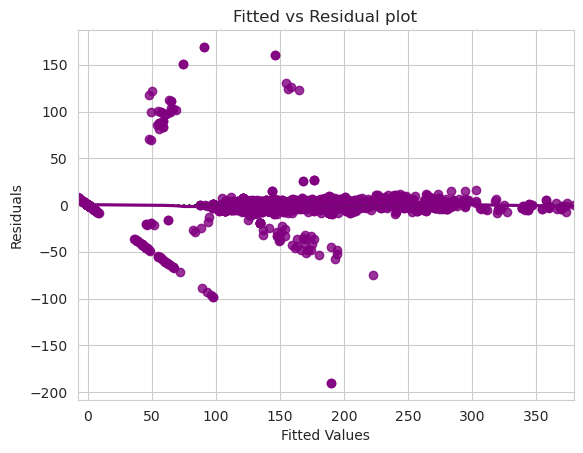

In [33]:
sns.set_style("whitegrid")
sns.residplot(
    data=df_pred, x="Fitted Values", y="Residuals", color="purple", lowess=True
)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted vs Residual plot")
plt.show()

**Observation**

* The pattern and data points seems to be randomly distributed.
* The linearity and Independence test has been passed by the model.

## Test for Normality by plotting the distribution of the residuals and Q-Q Plot


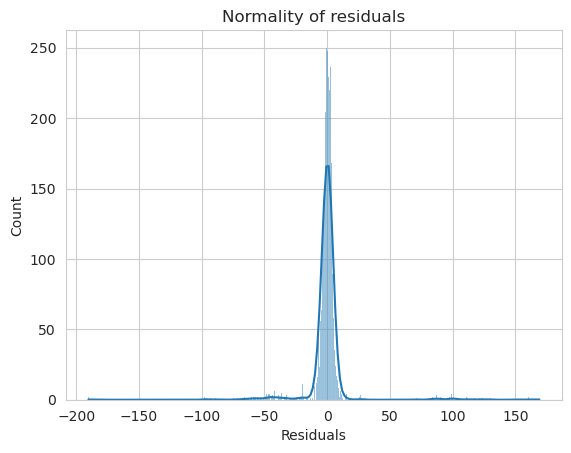

In [34]:
# Plotting the distribution of the residuals

sns.histplot(df_pred["Residuals"], kde=True)
plt.title("Normality of residuals")
plt.show()

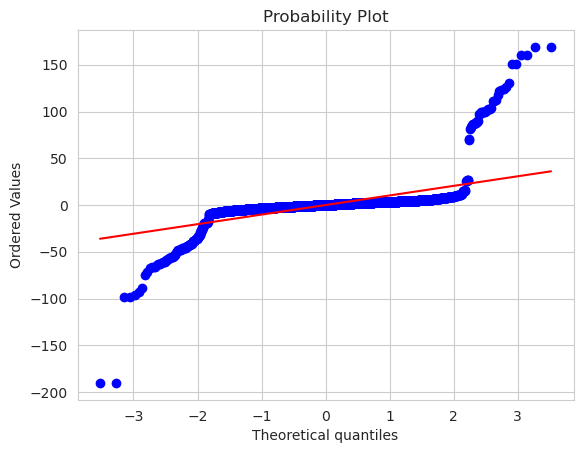

In [35]:
# Performing a Q-Q plot of the residuals

import pylab
import scipy.stats as stats

stats.probplot(df_pred["Residuals"], dist="norm", plot=pylab)
plt.show()

Observation

* The residual distribution plot shows that the residuals are normally distributed
* Most of the points are lying on the straight line in QQ plot
* In conclusion, the fitted model has passed the normality test

### Test for Homoscedasticity using the The null and alternate hypotheses of the goldfeldquandt test are as follows:

* Null hypothesis : Residuals are homoscedastic
* Alternate hypothesis : Residuals have hetroscedasticity

In [36]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(df_pred["Residuals"], X_train6)
lzip(name, test)

[('F statistic', 0.8414585157486741), ('p-value', 0.9997243490027432)]

**Observation**

* Since p-value > 0.05 we can say that the residuals are homoscedastic. The fitted model has passed the homoscedastic test.
* Also, the predictor variables have their p-values below 0.05 and the linear model assumption has been passed. We therefore adopt olsres_4 model as the final model for prediction


## Final Model

In [37]:
# printing the summary of the accepted model

print(olsres_6.summary())

                            OLS Regression Results                            
Dep. Variable:               WLTP_CO2   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     3365.
Date:                Thu, 20 Jul 2023   Prob (F-statistic):               0.00
Time:                        08:39:16   Log-Likelihood:                -13610.
No. Observations:                3237   AIC:                         2.725e+04
Df Residuals:                    3223   BIC:                         2.733e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### Observations

* R-squared of the model is 0.93 and adjusted R-squared is 0.93, which shows that the model is able to explain ~80% variance in the data. This is quite good.

## Predictions

In [38]:
# let's check the model parameters

olsres_6.params

const                                    15.303544
Engine_Capacity                           0.003617
Maximum_range_(Km)                       -0.024503
Equivalent_All_Electric_Range_KM          0.156687
Annual_Electricity_cost_/_10000_miles    -0.087680
Total_cost_/_10000_miles                  0.078815
Noise_Level_dB(A)                        -0.077222
Emissions_CO_[mg/km]                      0.014725
THC_Emissions_[mg/km]                    -0.116588
THC_+_NOx_Emissions_[mg/km]               0.099754
Particulates_[No.]_[mg/km]                1.884424
Fuel_Type_Petrol                        -13.033339
Fuel_Type_Petrol / LPG                   50.870454
Fuel_Type_Petrol Electric               -12.824876
dtype: float64

In [39]:
# Let us write the equation of linear regression

Equation = "WLTP_CO2 ="
print(Equation, end=" ")
for i in range(len(X_train6.columns)):
    if i == 0:
        print(olsres_6.params[i], "+", end=" ")
    elif i != len(X_train6.columns) - 1:
        print(
            olsres_6.params[i],
            "* (",
            X_train6.columns[i],
            ")",
            "+",
            end="  ",
        )
    else:
        print(olsres_6.params[i], "* (", X_train6.columns[i], ")")

WLTP_CO2 = 15.303543531066566 + 0.003616582796798752 * ( Engine_Capacity ) +  -0.024503226090514977 * ( Maximum_range_(Km) ) +  0.15668660457917802 * ( Equivalent_All_Electric_Range_KM ) +  -0.08768042992244307 * ( Annual_Electricity_cost_/_10000_miles ) +  0.07881514523097044 * ( Total_cost_/_10000_miles ) +  -0.07722195933385244 * ( Noise_Level_dB(A) ) +  0.014724510945445489 * ( Emissions_CO_[mg/km] ) +  -0.11658794534723299 * ( THC_Emissions_[mg/km] ) +  0.09975435930658103 * ( THC_+_NOx_Emissions_[mg/km] ) +  1.8844240861620367 * ( Particulates_[No.]_[mg/km] ) +  -13.033338814645559 * ( Fuel_Type_Petrol ) +  50.87045412962712 * ( Fuel_Type_Petrol / LPG ) +  -12.824876329563144 * ( Fuel_Type_Petrol Electric )


In [ ]:
# Visualizing  the actual train data and predicted CO2 emmissions

sns.distplot(df_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [ ]:
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump()

### Making predictions on the test data.

In [40]:
# Identify columns in the training and test dataset
train_columns = set(X_train6.columns)
test_columns = set(X_test.columns)

# Compare columns
columns_to_drop = test_columns - train_columns

# Drop columns from the test dataset
X_test.drop(columns=columns_to_drop, inplace=True)

In [41]:
# Making predictions on the test set

y_pred = olsres_6.predict(X_test)
rmse1 = np.sqrt(mean_squared_error(y_train, y_pred["Fitted Values"]))
rmse1

16.207150428871444

In [ ]:
# Visualizing  the actual test data and predicted CO2 emmissions

sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [42]:
# let's check the RMSE on the test data

rmse2 = np.sqrt(mean_squared_error(y_test, y_pred))
rmse2

11.940914915823837

In [ ]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

**Observation**

* The RMSE on the train and test sets are comparable. So, our model is not suffering from overfitting.
* We can conclude the model "ols_res6" is good for prediction as well as inference purposes.